# Harvesting course metadata

## Tuija Sonkkila 

To take my baby steps in Python and particularly web scraping, I harvested core metadata from Aalto courses by School and department. The [courses.aalto.fi](https://courses.aalto.fi) site is built by similar blocks of HTML code, which makes the work relatively easy.

Initially, I thought that I'd manage only with [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) but soon found out that it was not enough. There were two reasons why the course pages were not that straightforward than I thought, and why I needed [selenium](https://www.seleniumhq.org/). Firstly, there is an occasional GDPR consent that you need to click as approval, otherwise you cannot proceed. Secondly, most of the course pages contain JavaScript that renders the page ready as you scroll down. In other words, all data is not there for you to start with, you need to scroll all the way down first. When you have overcome these obstacles thanks to selenium, you can pass the page content to BeautifulSoup.

So, I needed to somehow automate the browser experience, as if I'd be there myself clicking and scrolling only I would not but it'd be my Python code. The keywords are a [headless browser](https://en.wikipedia.org/wiki/Headless_browser), and a _web driver_ that gives Python programmatic handles to the innards of the browser, in this case Google Chrome. A headless browser is basically a browser without the graphical user interface. You want to bypass all things graphical because you are not there to interact with them. The web driver offers different classes that help you do what you want to do. In my case, these would be finding the HTML element with the GDPR consent, and scrolling to the bottom of the page.

The other packages are for regular expressions (re), timing (time), making HTTP requests (requests), working with data frames (pandas), and plotting (matplotlib).

In its present state, the script takes about 8 minutes to run. Some extra time - maybe a minute or so - comes from the fact that I added few seconds to work with those pages where I needed to go to the bottom first. I'm not sure if it's necessary but I wanted to be on the safe side and not miss anything.

Note that the script assumes that everything is fine at course.aalto.fi, and that no hiccups happens during scraping. A proper script would have a decent exception handling. 

For the basic layout with functions and all, I thank [this GitHub gist](https://gist.github.com/suriyadeepan/295ea86cf8f6d6556b1487ffed59939f) for inspiration.

The site does not explicitly deny scraping but please run respectfully, if you do.

In [57]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

from bs4 import BeautifulSoup
import pandas as pd
import re
import time
import requests

import matplotlib.pyplot as plt

In [57]:
base_url = 'https://courses.aalto.fi/school/'
domain = 'https://courses.aalto.fi'
schools = ["ARTS", "BIZ", "CHEM", "ELEC", "ENG", "SCI"]

In [16]:
''' prepare headless driver '''
def headless_driver():
    options = Options()
    options.add_argument("--headless")
    driver = webdriver.Chrome(options = options)
    return driver

In [17]:
''' get soup '''
def get_soup(url):
    content = requests.get(url).content
    return BeautifulSoup(content,'lxml') 

In [45]:
''' get soup from selenium '''
def get_soup_from_selenium(url):    
    driver = headless_driver()    
    driver.get(url)
    # Accept GDPR cookie consent
    driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/div/div/button').click()
    # Scroll to bottom so that everything is returned
    # https://stackoverflow.com/a/51345544
    html = driver.find_element_by_tag_name('html')
    html.send_keys(Keys.END)
    # Wait a bit to get it all
    time.sleep(3.5)    
    # Hand over to BS
    return BeautifulSoup(driver.page_source, 'lxml')

In [44]:
''' return a list of links to departments '''
def extract_departments(url):
    soup = get_soup(url)
    depts = soup.find_all("a", class_ = re.compile("^Department"))
    depts_links = []
    
    for i in depts:
        link = domain + i.get('href')
        depts_links.append(link)
        
    return depts_links

In [46]:
''' return metadata from courses '''
def extract_courses(url, school):  
    schools = []
    depts = []
    links = []
    titles = []
    codes = []
    credits = []
    languages = []
    descriptions = []
    
    soup = get_soup_from_selenium(url)
    
    # Department name
    department = soup.find("h2").text
    dstring = re.search('^(.*)\s\(', department)
    d = dstring.group(1)
    
    courses = soup.find_all("a", class_ = re.compile("^CourseRow"))
    
    for i in courses:
        # School
        schools.append(prefix + school)
        # Department
        depts.append(d)
        # URL
        link = domain + i.get('href')
        links.append(link)
        # Description
        coursecontent = requests.get(link)
        coursesoup = BeautifulSoup(coursecontent.text, 'html.parser')
        ps = coursesoup.select('main > div > div > span > p')
        text = ''.join(p.get_text(strip=True) for p in ps)
        descriptions.append(text)
        # Title
        titles.append(i.find("h3").text)
        # Course code
        codes.append(i.find_all("span")[0].text)
        # Credits
        credits.append(i.find("span", class_ = re.compile("^Credits")).text)
        # Language
        img = i.findChild('img')
        if img:
            languages.append(i.find("img", class_ = re.compile("^CourseRow__StyledFlag")).get('alt'))
        else:
            languages.append('NA')
            
    courses_df = pd.DataFrame({
        'school': schools,
        'dept': depts,
        'title': titles,
        'url': links,
        'code': codes,
        'credits': credits,
        'language': languages,
        'description' : descriptions
    })
        
    return courses_df

In [ ]:
''' main section '''
if __name__ == '__main__':
    courses_from_all_schools = []
    
    start = time.time()
    
    for s in schools:
        print("Harvesting school", s, "\n")
        start_url = base_url + s     
        depts = extract_departments(start_url)
        all_courses_from_this_school = []
        
        for d in depts:
            dept_courses = extract_courses(d, s)
            all_courses_from_this_school.append(dept_courses)
            
        all_courses_from_this_school_df = pd.concat(all_courses_from_this_school)         
        courses_from_all_schools.append(all_courses_from_this_school_df)
      
    courses_from_all_schools_df = pd.concat(courses_from_all_schools)
    
    courses_from_all_schools_df.to_csv("aaltocourses.csv", sep='\t', index=False)
    
    end = time.time()-start
    print("The script took this many minutes to run:", round(end/60,2))

## Languages

Ok, so how much are we giving courses in different languages on the School level? 

In [12]:
data = pd.read_csv("aaltocourses.csv", sep = "\t")

# Although just the acronyms are in everyday use, the official wording includes Aalto as a prefix
data.replace({'ARTS': 'Aalto ARTS', 'BIZ': 'Aalto BIZ', 'CHEM': 'Aalto CHEM', 'ELEC': 'Aalto ELEC', 'ENG': 'Aalto ENG', 'SCI': 'Aalto SCI'}, inplace=True)
data.head()

,school,dept,title,url,code,credits,language,description
0,Aalto ARTS,Architecture,"Advanced Course in Landscape Construction, Studio",https://courses.aalto.fi/course/MAR-E1030,MAR-E1030,10-15 op,fi,Syventää maisemarakentamisen tekniikan tuntemu...
1,Aalto ARTS,Architecture,Algorithmic Design,https://courses.aalto.fi/course/ARK-E2513,ARK-E2513,3-6 op,en,The course deals with methods of algorithmic d...
2,Aalto ARTS,Architecture,Analysis Course,https://courses.aalto.fi/course/ARK-C4502,ARK-C4502,2 op,fi,"As part of a group, each student participates ..."
3,Aalto ARTS,Architecture,Architect as Principal Designer,https://courses.aalto.fi/course/ARK-E3501,ARK-E3501,2 op,fi,Getting to know the duties of the principal de...
4,Aalto ARTS,Architecture,Architectural Graphics,https://courses.aalto.fi/course/ARK-C1500,ARK-C1500,2-4 op,fi,The course acquaints the students with graphic...


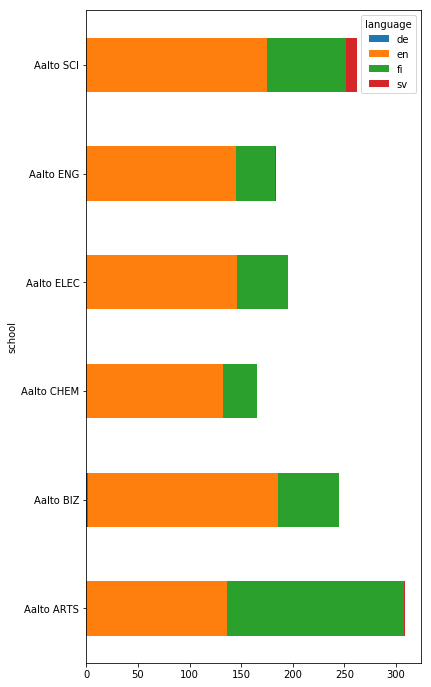

In [58]:
data.groupby(['school', 'language']).size().unstack().plot(kind='barh', stacked=True)

The number of courses is biggest at Aalto ARTS. What about the percentages by language? 

Below, I'm testing grouping for the first time, and then making a visualization based on [this hint](https://stackoverflow.com/a/36784698).

In [40]:
grouped = (data.groupby(by=['school','language'])['language']
           .agg({'count':'count'})
           .sort_values(by=["school","count"],ascending=True))

# https://stackoverflow.com/a/23377232
grouped = grouped.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

grouped

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


count
school     language           
Aalto ARTS sv         0.323625
           en        44.012945
           fi        55.663430
Aalto BIZ  de         0.816327
           fi        24.081633
           en        75.102041
Aalto CHEM fi        20.000000
           en        80.000000
Aalto ELEC fi        25.128205
           en        74.871795
Aalto ENG  sv         0.543478
           fi        20.652174
           en        78.804348
Aalto SCI  sv         3.816794
           fi        29.389313
           en        66.793893

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


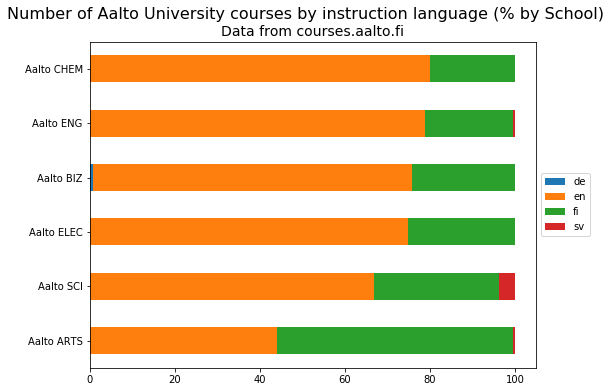

In [71]:
# My code becomes rather messy at this point. I need more practice on how to define a plot
plt.rcParams["figure.figsize"] = (8,6)

lang = grouped.pivot_table(values=['count'], 
                      index='school',
                      columns='language')

lang.columns = lang.columns.droplevel()
lang = lang.sort_values(by=(["en","fi"]))
lang.plot(kind='barh', stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.axes().yaxis.label.set_visible(False)
plt.title('Data from courses.aalto.fi',fontsize=14)
plt.suptitle('Number of Aalto University courses by instruction language (% by School)',fontsize=16, y=0.96)

plt.savefig('aalto_courses_lang_school.png', bbox_inches='tight', transparent = False)

Here we can see that in ARTS, over 50% of courses are in Finnish. CHEM and ENG come close in being the top ones offering courses in English.

How does the situation look like at the departmental level?

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


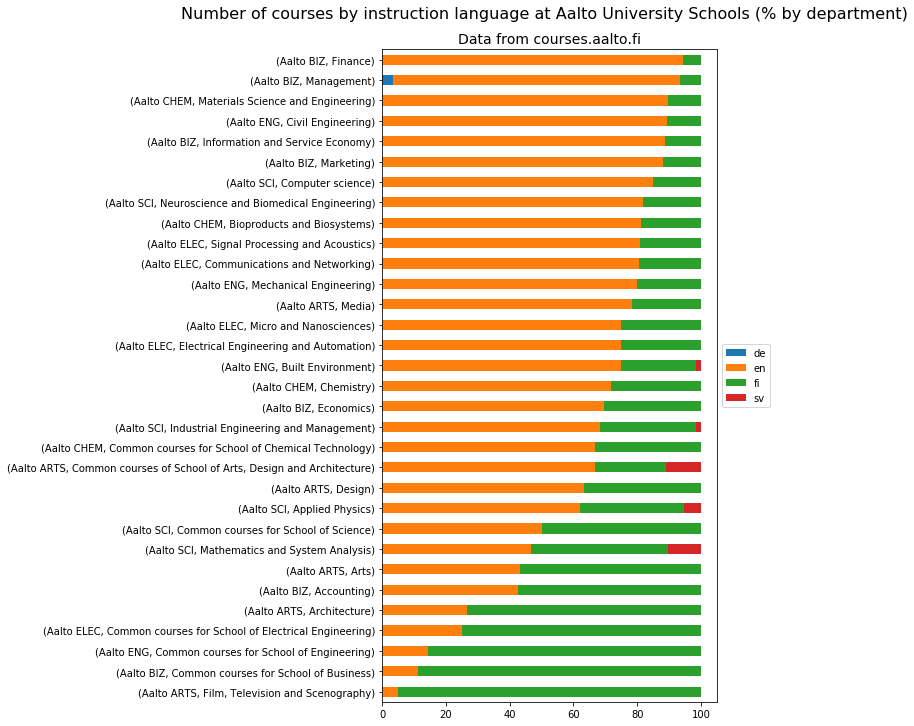

In [79]:
plt.rcParams["figure.figsize"] = (6,12)

grouped_dept = (data.groupby(by=['school','dept','language'])['language']
           .agg({'count':'count'}))

grouped_dept = grouped_dept.groupby(level=1).apply(lambda x:
                                                 100 * x / float(x.sum()))

lang_dept = grouped_dept.pivot_table(values=['count'], 
                      index=('school','dept'),
                      columns='language')

lang_dept.columns = lang_dept.columns.droplevel()
lang_dept = lang_dept.sort_values(by=(["en","fi"]))

lang_dept.plot(kind='barh', stacked=True).legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.axes().yaxis.label.set_visible(False)
plt.title('Data from courses.aalto.fi',fontsize=14)
plt.suptitle('Number of courses by instruction language at Aalto University Schools (% by department)',fontsize=16, y=0.93)

plt.savefig('aalto_courses_lang_dept.png', bbox_inches='tight', transparent = False)

Some more interesting differences here. 

The most English department course-wise is Finance in BIZ. Perhaps not a surprise? What *are* minor surprises at least for me are that there are quite a few courses (~10%) in Swedish at *Mathematics and System Analysis*, and even some courses in German at *Management*. I wonder if this is because of the native language of the respective teachers/professors?

Actually, a stacked barchart this big does not serve very well I think. Some day I'll try to do a faseted grid by School. I've understood that [seaborn](https://seaborn.pydata.org/) is the way to go.